In [1]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map

from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    #PowerLawNuisanceSpectralModel,
    #PowerLawNormNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('/home/katrin/Documents/nuisance_summary/E_reco/irf_model/')

from Dataset_Creation import sys_dataset
from gammapy.modeling.models.IRF import IRFModel, ERecoIRFModel, IRFModels


In [2]:
figformat = 'svg'

In [3]:
import json
with open("/home/katrin/Documents/nuisance_summary/E_reco/irf_model/config.json") as json_data_file:

    config = json.load(json_data_file)
config = config['local']
print(config)
source = 'Crab'
path = config["path"]
path_crab = config["path_crab"]


dataset_load = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_load = dataset_load.downsample(4)
models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

bkg_model = FoVBackgroundModel(dataset_name=dataset_load.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)

dataset_load.models = models
dataset_load.counts = dataset_load.npred()

{'path': '/home/katrin/Documents', 'path_crab': '/home/katrin/Documents/Crab'}


In [4]:
biass = [0.0]
sigmass = [0.3]
sigma_assumed = 0.3

In [22]:
ereco = ERecoIRFModel()
print(ereco.parameters.names)
IRFmodels = IRFModels(e_reco_model= ereco,
                     )
models_test = Models()
models_test.append(IRFmodels)
print(models_test)
#print(IRFmodels.e_reco_model())

IRFmodels.covariance

['bias', 'resolution']
Models

Component 0: IRFModels

type    name      value    unit   error   min max frozen is_norm is_penalised link
---- ---------- ---------- ---- --------- --- --- ------ ------- ------------ ----
 irf       bias 0.0000e+00      0.000e+00 nan nan  False   False         True     
 irf resolution 0.0000e+00      0.000e+00 nan nan  False   False         True     


AttributeError: 'IRFModels' object has no attribute '_covariance'

In [23]:
ereco.covariance

In [6]:
def create_dataset(b, s):
    sys_d_cor = sys_dataset(dataset_asimov= dataset_load,
                        shift = 0,
                        tilt = 0,
                        bias = 0, 
                        sigma = s,
                        rnd = False,
                        e_reco_creation=10)
    dataset_conv = sys_d_cor.create_dataset()
    dataset_conv_N = sys_d_cor.create_dataset_N(1)
    #dataset_conv_N.models.parameters['norm_nuisance'].frozen  = True
    #dataset_conv_N.models.parameters['tilt_nuisance'].frozen  = True
    dataset_conv_N.models.parameters['bias'].frozen  = True
    #dataset_conv_N.models.parameters['resolution'].frozen  = True
    #dataset_conv_N.models.parameters['resolution'].value  = s
    dataset_conv_N.e_reco_n = 1
    
    # new fine binned IRF Model
    dataset_conv_N_fine =  sys_d_cor.create_dataset_N(10)

    zero = 1e-12
    penalising_invcovmatrix = np.zeros((2,2))
    if b ==0 :
        b_ = zero
    else:
        b_ = b
    #np.fill_diagonal(penalising_invcovmatrix, [1/zero**2, 1/zero**2, 1/b_**2, 1/sigma_assumed**2])
    np.fill_diagonal(penalising_invcovmatrix, [1/b_**2, 1/sigma_assumed**2])
    dataset_conv_N.penalising_invcovmatrix = penalising_invcovmatrix
    dataset_conv_N_fine.penalising_invcovmatrix = penalising_invcovmatrix
    return dataset_conv, dataset_conv_N, dataset_conv_N_fine

dataset_conv, dataset_conv_N , dataset_conv_N_fine = create_dataset(biass[0], sigmass[0])
datasets_conv = Datasets([dataset_conv])
datasets_conv_N = Datasets([dataset_conv_N])
datasets_conv_N_fine = Datasets([dataset_conv_N_fine])


in map: 0.3
evaluate: 0.3 0.0
10
in map: 0.3
evaluate: 0.3 0.0
10
in map: 0.3
evaluate: 0.3 0.0
10


In [7]:
def sum_e (data):
    return data.sum(axis=2).sum(axis=1)

eaxis_standard = dataset_load.geoms['geom'].axes[0]

in map: 0.0
evaluate: 0.0 0.0
1


<WCSAxesSubplot: >

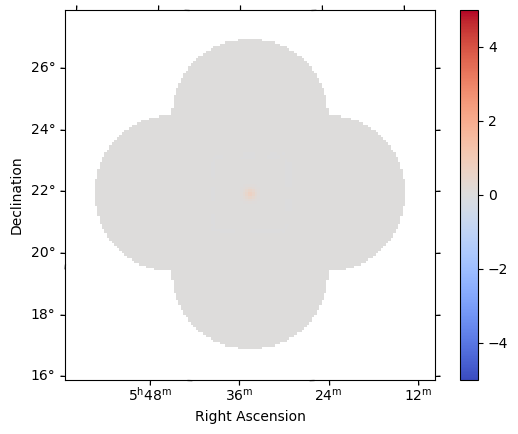

In [8]:
d = dataset_conv_N
d.plot_residuals_spatial()

in map: 0.0
evaluate: 0.0 0.0
1
in map: 0.0
evaluate: 0.0 0.0
10


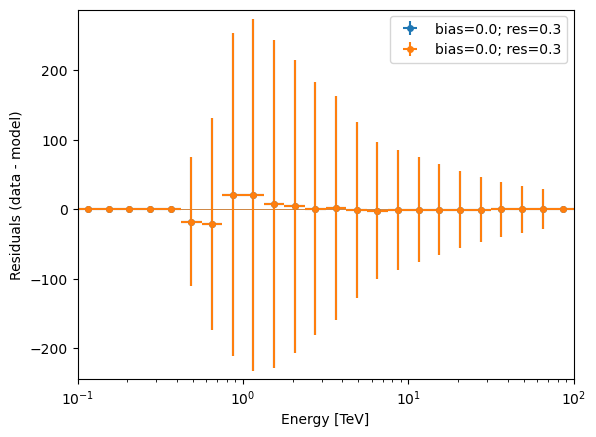

In [9]:
fig, ax = plt.subplots()
i = 0
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for b in biass:
    for s in sigmass:
        d = datasets_conv_N[i]
        d.plot_residuals_spectral(ax =ax, color= colors[i], 
                    label = f"bias={b}; res={s}")
        d = datasets_conv_N_fine[i]
        d.plot_residuals_spectral(ax =ax, color= colors[1], 
                    label = f"bias={b}; res={s}")
        i += 1
ax.legend()


in map: 0.0
evaluate: 0.0 0.0
1
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
1
in map: 0.0
evaluate: 0.0 0.0
10


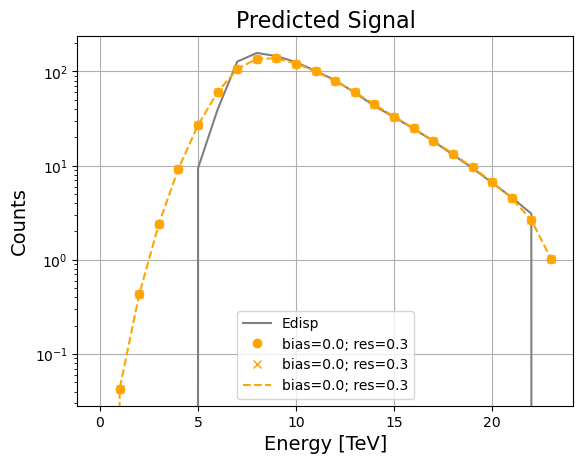

In [10]:
import matplotlib.pyplot as plt

# Your data processing code here

plt.title("Predicted Signal", fontsize=16)
i = 0 
fmts = ['o', 'x', '--', ':']
colors = ['orange', 'red', 'tab:blue', 'green']
plt.plot(sum_e(dataset_load.counts.data-dataset_load.background.data),
         label = "Edisp", color = 'grey')
npreds_pre_fit = []
npreds_pre_fit_N = []
npreds_pre_fit_N_fine = []
for b in biass:
    for s in sigmass:
        npreds_pre_fit.append( sum_e(datasets_conv[i].npred_signal().data))
        npreds_pre_fit_N.append( sum_e(datasets_conv_N[i].npred_signal().data))
        npreds_pre_fit_N_fine.append( sum_e(datasets_conv_N_fine[i].npred_signal().data))
        
        plt.plot( sum_e(datasets_conv[i].npred_signal().data),
                 fmts[i], label = f"bias={b}; res={s}", color = colors[i])
        plt.plot( sum_e(datasets_conv_N[i].npred_signal().data),
                 'x', label = f"bias={b}; res={s}", color = colors[i])
        plt.plot( sum_e(datasets_conv_N_fine[i].npred_signal().data),
                 '--', label = f"bias={b}; res={s}", color = colors[i])
        i += 1
        
#plt.ylim(1e-1, 4e2)
plt.yscale('log')
plt.legend()
plt.xlabel("Energy [TeV]", fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.grid(True)
fig = plt.gcf()
#fig.savefig(f"plots/1_Npred_bias={bias}sigma={sigma}.png", dpi=300, quality=95)

corr
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -7.536e+05                 │              Nfcn = 513              │
│ EDM = 2.98e-05 (Goal: 2e-06)     │            time = 5.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────────┬───────────┬───────────┬────────────┬────────────┬────────

in map: -0.0010343887584393949
evaluate: -0.0010343887584393949 0.0
1
in map: 0.03188685063839727
evaluate: 0.03188685063839727 0.0
1
in map: -0.03395562815527605
evaluate: -0.03395562815527605 0.0
1
in map: 0.12109705309685931
evaluate: 0.12109705309685931 0.0
1
in map: -0.12316583061373809
evaluate: -0.12316583061373809 0.0
1
in map: 0.032289376728833225
evaluate: 0.032289376728833225 0.0
1
in map: -0.03435815424571201
evaluate: -0.03435815424571201 0.0
1
in map: 0.12032098813171639
evaluate: 0.12032098813171639 0.0
1
in map: -0.12238976564859518
evaluate: -0.12238976564859518 0.0
1
in map: 0.0322584575042847
evaluate: 0.0322584575042847 0.0
1
in map: -0.034327235021163485
evaluate: -0.034327235021163485 0.0
1
in map: -0.0053794706234419915
evaluate: -0.0053794706234419915 0.0
1
in map: -0.0028815489474287434
evaluate: -0.0028815489474287434 0.0
1
in map: -0.0018896591648733647
evaluate: -0.0018896591648733647 0.0
1
in map: -0.0014449317996890565
evaluate: -0.0014449317996890565 0.0


1
in map: -0.0009093311474296913
evaluate: -0.0009093311474296913 0.0
1
in map: -0.0009093311474296913
evaluate: -0.0009093311474296913 0.0
1
in map: -0.0009093311474296913
evaluate: -0.0009093311474296913 0.0
1
in map: -0.0009093311474296913
evaluate: -0.0009093311474296913 0.0
1
in map: -0.0009093311474296913
evaluate: -0.0009093311474296913 0.0
1
in map: -0.0009093311474296913
evaluate: -0.0009093311474296913 0.0
1
in map: -0.0009093311474296913
evaluate: -0.0009093311474296913 0.0
1
in map: -0.0009093311474296913
evaluate: -0.0009093311474296913 0.0
1
in map: -0.0009093311474296913
evaluate: -0.0009093311474296913 0.0
1
in map: -0.0009093311474296913
evaluate: -0.0009093311474296913 0.0
1
in map: 0.03238577980934007
evaluate: 0.03238577980934007 0.0
1
in map: -0.034204442104199456
evaluate: -0.034204442104199456 0.0
1
in map: 0.12060460697669902
evaluate: 0.12060460697669902 0.0
1
in map: -0.1224232692715584
evaluate: -0.1224232692715584 0.0
1
in map: 0.03238958681252441
evaluate: 

in map: 0.0006893718987732713
evaluate: 0.0006893718987732713 0.0
1
in map: -0.0001630264965292753
evaluate: -0.0001630264965292753 0.0
1
in map: -0.0005490832394980012
evaluate: -0.0005490832394980012 0.0
1
in map: -0.0007326598479609921
evaluate: -0.0007326598479609921 0.0
1
in map: -0.0008220628790921933
evaluate: -0.0008220628790921933 0.0
1
in map: -0.0008660148336065035
evaluate: -0.0008660148336065035 0.0
1
in map: -0.0008878550797392359
evaluate: -0.0008878550797392359 0.0
1
in map: -0.0008987149715982515
evaluate: -0.0008987149715982515 0.0
1
in map: -0.0009041097875607651
evaluate: -0.0009041097875607651 0.0
1
in map: -0.0009041097875607651
evaluate: -0.0009041097875607651 0.0
1
in map: -0.0009041097875607651
evaluate: -0.0009041097875607651 0.0
1
in map: -0.0009041097875607651
evaluate: -0.0009041097875607651 0.0
1
in map: -0.0009041097875607651
evaluate: -0.0009041097875607651 0.0
1
in map: -0.0009041097875607651
evaluate: -0.0009041097875607651 0.0
1
in map: -0.00090410978

in map: -0.03420278779251597
evaluate: -0.03420278779251597 0.0
1
in map: 0.12060386825139802
evaluate: 0.12060386825139802 0.0
1
in map: -0.12241208782651955
evaluate: -0.12241208782651955 0.0
1
in map: 0.032394564085560955
evaluate: 0.032394564085560955 0.0
1
in map: -0.03420278366068249
evaluate: -0.03420278366068249 0.0
1
in map: 0.12060386680269142
evaluate: 0.12060386680269142 0.0
1
in map: -0.12241208637781295
evaluate: -0.12241208637781295 0.0
1
in map: 0.009396025039059421
evaluate: 0.009396025039059421 0.0
1
in map: 0.0027705368464081676
evaluate: 0.0027705368464081676 0.0
1
in map: 0.0006843950038226847
evaluate: 0.0006843950038226847 0.0
1
in map: -0.00016280565052761617
evaluate: -0.00016280565052761617 0.0
1
in map: -0.0005463929136445234
evaluate: -0.0005463929136445234 0.0
1
in map: -0.0007287458520506822
evaluate: -0.0007287458520506822 0.0
1
in map: -0.0008175235097644442
evaluate: -0.0008175235097644442 0.0
1
in map: -0.0008612080481734939
evaluate: -0.00086120804817

1
in map: -0.0009041097875607651
evaluate: -0.0009041097875607651 0.0
1
in map: -0.0009041097875607651
evaluate: -0.0009041097875607651 0.0
1
in map: -0.0009041097875607651
evaluate: -0.0009041097875607651 0.0
1
in map: -0.0009041097875607651
evaluate: -0.0009041097875607651 0.0
1
in map: -0.0009041097875607651
evaluate: -0.0009041097875607651 0.0
1
in map: -0.0009041097875607651
evaluate: -0.0009041097875607651 0.0
1
in map: -0.0009041097875607651
evaluate: -0.0009041097875607651 0.0
1
in map: -0.0009041097875607651
evaluate: -0.0009041097875607651 0.0
1
in map: -0.0009041097875607651
evaluate: -0.0009041097875607651 0.0
1
in map: 0.032397284867479954
evaluate: 0.032397284867479954 0.0
1
in map: -0.03420550444260149
evaluate: -0.03420550444260149 0.0
1
in map: -0.0009041097875607651
evaluate: -0.0009041097875607651 0.0
1
in map: -0.0009041097875607651
evaluate: -0.0009041097875607651 0.0
1
in map: -0.0009041097875607651
evaluate: -0.0009041097875607651 0.0
1
in map: -0.000904109787560

AttributeError: 'IRFModels' object has no attribute '_covariance'

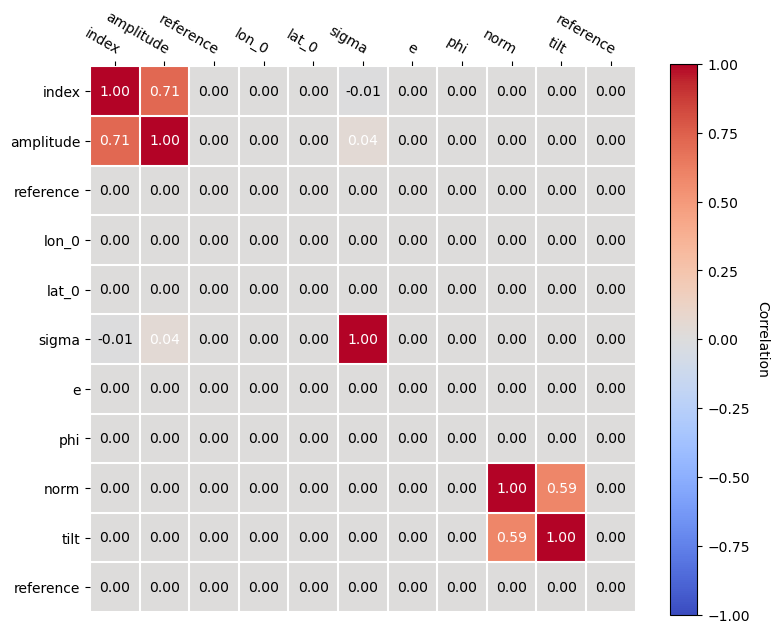

In [11]:
%%time
print("corr")
fit_cor = Fit(store_trace=True)
minuit_opts = {"tol": 0.001, "strategy": 2}
fit_cor.optimize_opts = minuit_opts
result_cor = fit_cor.run(datasets_conv)
datasets_conv.models.covariance = fit_cor.covariance(datasets_conv).matrix
datasets_conv.models.covariance.plot_correlation()
print(fit_cor.minuit)

fit_cor_N = Fit(store_trace=True)
fit_cor_N.optimize_opts = {"tol": 0.001, "strategy": 2}
result_cor_N = fit_cor_N.run(datasets_conv_N)
datasets_conv_N.models.covariance = fit_cor_N.covariance(datasets_conv_N).matrix
datasets_conv_N.models.covariance.plot_correlation()
print(fit_cor_N.minuit)
    
'''fit_cor_N_fine = Fit(store_trace=True)
fit_cor_N_fine.optimize_opts = {"tol": 0.001, "strategy": 2}
result_cor_N_fine = fit_cor_N_fine.run(datasets_conv_N_fine)
datasets_conv_N_fine.models.covariance = fit_cor_N_fine.covariance(datasets_conv_N_fine).matrix
datasets_conv_N_fine.models.covariance.plot_correlation()
print(fit_cor_N_fine.minuit)'''



        

In [12]:
for p in datasets_conv_N.models.parameters.penalised_parameters:
    p.frozen = True
    print(p.name)
        
for p in datasets_conv_N_fine.models.parameters.penalised_parameters:
    p.frozen = True
    print(p.name)

bias
resolution
bias
resolution


In [13]:
colors_standard = ['darkblue', 'sienna', 'darkolivegreen', 'darkred']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


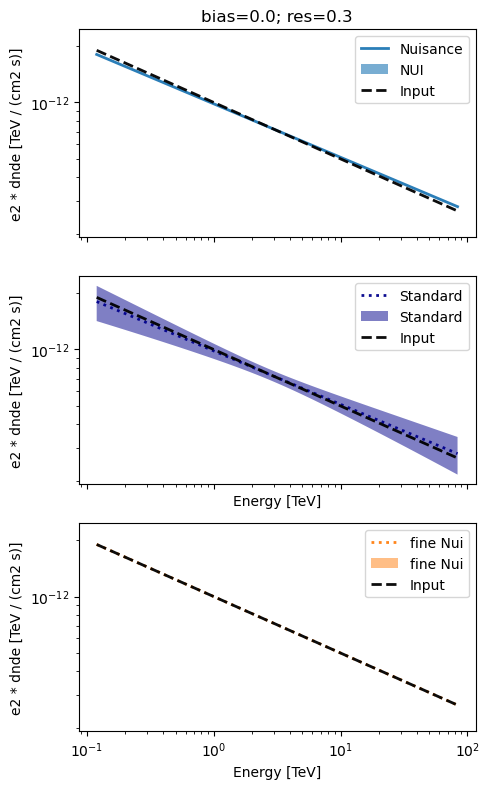

In [14]:
energy = datasets_conv[0].counts.geom.axes[0].center.value
energy_bounds = (energy[0], energy[-1] ) * u.TeV


fig,axs = plt.subplots(3,1, sharex = True, sharey=True, figsize = (5,8))
#axs = [axs]
i =0; ii =0
for b in biass:
    for s in sigmass:
        
        d = datasets_conv_N
    
        d.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[ii],
                                                               color=colors[ii],
                                                                 label= f"Nuisance",
                                                                alpha = 0.95,
                                                               linestyle='-', linewidth= 2)       

        d.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[ii],
                                                               facecolor=colors[ii],
                                                                 label="NUI",
                                                                alpha = 0.6)
        d = datasets_conv
        d.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[ii+1],
                                                               color=colors_standard[ii],
                                                                 label= f"Standard",
                                                                alpha = 0.95,
                                                               linestyle=':', linewidth= 2)       

        d.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[ii+1],
                                                               facecolor=colors_standard[ii],
                                                                 label="Standard",
                                                                alpha = 0.5)
        
        d = datasets_conv_N_fine
        d.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[ii+2],
                                                               color=colors[ii+1],
                                                                 label= f"fine Nui",
                                                                alpha = 0.95,
                                                               linestyle=':', linewidth= 2)       

        d.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[ii+2],
                                                               facecolor=colors[ii+1],
                                                                 label="fine Nui",
                                                                alpha = 0.5)
        
        axs[ii].set_title(f"bias={b}; res={s}")
        i +=1
        ii +=1
for a in axs:
    dataset_load.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = a,
                                                               color='black',
                                                                 label="Input",
                                                                alpha = 0.95,
                                                               linestyle='dashed', linewidth= 2)  
    a.legend()
    
ylim = axs[0].get_ylim()
axs[0].set_xlabel('')
plt.tight_layout()


in map: -0.0009041097875607651
evaluate: -0.0009041097875607651 0.0
1


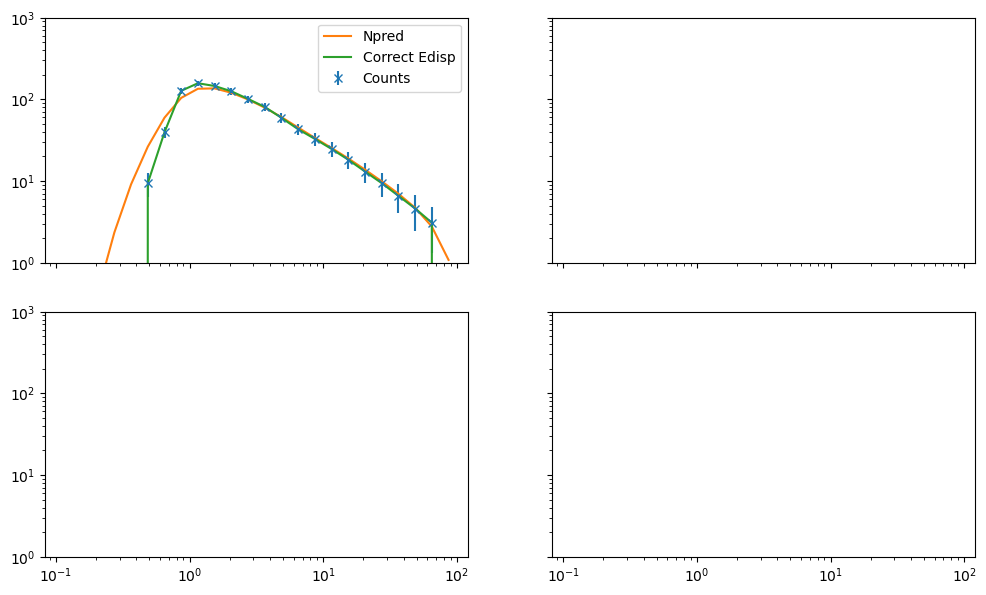

In [15]:
fig,axs = plt.subplots(2,2, sharex = True, sharey=True, figsize = (12,7))
axs = axs.flatten()
i =0; ii =0
for b in biass:
    for s in sigmass:
        d = datasets_conv_N[ii]
        axs[ii].errorbar(energy, sum_e(d.counts.data-d.background.data), 
                     yerr = np.sqrt(sum_e(d.counts.data-d.background.data)),
                    fmt = 'x', label = "Counts")

        axs[ii].plot(energy, sum_e(d.npred_signal().data), label = "Npred")
        axs[ii].plot(energy, sum_e(dataset_load.npred_signal().data), label = "Correct Edisp")
        
        
        
        axs[ii].loglog()
        axs[ii].legend()
        axs[ii].set_ylim(1e0, 1e3)        
        ii +=1
        


in map: -0.0009041097875607651
evaluate: -0.0009041097875607651 0.0
1


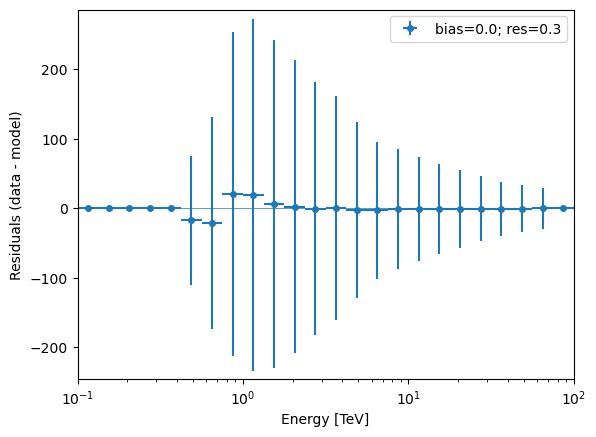

In [16]:
fig, ax = plt.subplots()
i = 0
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for b in biass:
    for s in sigmass:
        d = datasets_conv_N[i]
        d.plot_residuals_spectral(ax =ax, color= colors[i], 
                    label = f"bias={b}; res={s}")
        i += 1
ax.legend()


['Standard', 'B=0.0;\n R=0.3;\n nbin =1', 'B=0.0;\n R=0.3;\n nbin =10']


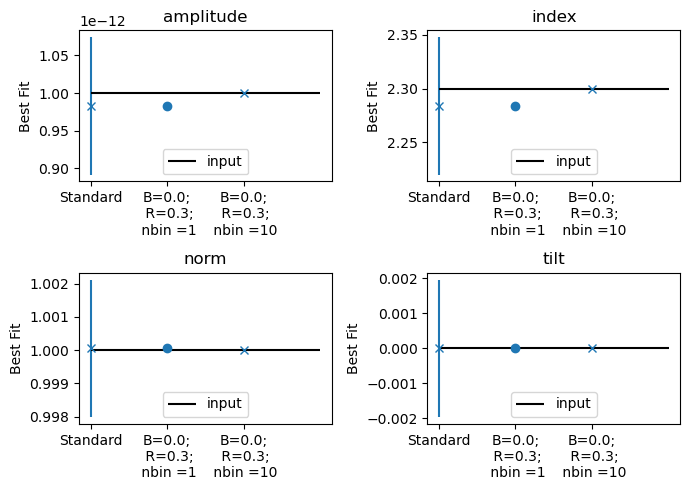

In [17]:
fig,ax  = plt.subplots(2,2,figsize= (7, 5))
ax = ax.flatten()
parnames = ['amplitude', 'index', 'norm', 'tilt']
labels_sys = []

ii =0;
for b in biass:
    for s in sigmass:
        d = datasets_conv[ii]
        for i, p in enumerate(parnames):
            value = d.models.parameters[p].value
            error = d.models.parameters[p].error    
            ax[i].errorbar(ii, value, yerr = error, fmt = 'x', color = colors[ii])
        labels_sys.append(f'Standard')
        
        d = datasets_conv_N[ii]
        for i, p in enumerate(parnames):
            value = d.models.parameters[p].value
            error = d.models.parameters[p].error    
            ax[i].errorbar(1, value, yerr = error, fmt = 'o', color = colors[ii])
        labels_sys.append(f'B={b};\n R={s};\n nbin =1')
            
        d = datasets_conv_N_fine[ii]
        for i, p in enumerate(parnames):
            value = d.models.parameters[p].value
            error = d.models.parameters[p].error    
            ax[i].errorbar(2, value, yerr = error, fmt = 'x', color = colors[ii])
        labels_sys.append(f'B={b};\n R={s};\n nbin =10')
            
        ii +=1
print(labels_sys)        
for i, p in enumerate(parnames):
    value = dataset_load.models.parameters[p].value
    error = dataset_load.models.parameters[p].error    
    #ax[i].errorbar(4, value, yerr = error, fmt = 'x')
    ax[i].hlines( value, 0, len(labels_sys), label = "input", color= 'black')
    ax[i].set_title(p)
    
    
for ax in ax:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), ncol = 1, 
            loc='lower center',)# bbox_to_anchor=(1, 0.5))
    ax.set_ylabel('Best Fit'); 
    #ax.set_xlabel('Systematic'); 
    ax.set_xticks(np.arange(len(labels_sys)),labels_sys)
    
plt.tight_layout()
    

In [18]:
print(datasets_conv_N_fine[0].models.parameters.to_table())

  type      name      value         unit        error      min        max    frozen is_norm is_penalised link
-------- ---------- ---------- -------------- --------- ---------- --------- ------ ------- ------------ ----
spectral      index 2.3000e+00                0.000e+00        nan       nan  False   False        False     
spectral  amplitude 1.0000e-12 cm-2 s-1 TeV-1 0.000e+00        nan       nan  False    True        False     
spectral  reference 1.0000e+00            TeV 0.000e+00        nan       nan   True   False        False     
 spatial      lon_0 8.3631e+01            deg 6.348e-04        nan       nan   True   False        False     
 spatial      lat_0 2.2018e+01            deg 8.726e-04 -9.000e+01 9.000e+01   True   False        False     
 spatial      sigma 1.9174e-02            deg 4.267e-03  0.000e+00       nan  False   False        False     
 spatial          e 0.0000e+00                0.000e+00  0.000e+00 1.000e+00   True   False        False     
 spatial  

In [19]:
datasets_conv_N[0].models.parameters['norm_nuisance'].value = 0.1
print(datasets_conv_N[0].models.parameters.to_table())

IndexError: No parameter: 'norm_nuisance'

In [ ]:
print(datasets_conv[0].models.parameters.to_table())

In [ ]:
fig,ax  = plt.subplots(1,2,figsize= (7, 2.5))
ax = ax.flatten()
parnames = ['bias', 'resolution',]
labels_sys = []

ii =0;
for b in biass:
    for s in sigmass:
        d = datasets_conv_N[ii]
        for i, p in enumerate(parnames):
            value = d.models.parameters[p].value
            error = d.models.parameters[p].error    
            ax[i].errorbar(ii, value, yerr = error, fmt = 'o', color = colors[ii])
            ax[i].set_title(p)
        labels_sys.append(f'B={b};\n R={s};\n nbin =1')
            
        d = datasets_conv_N_fine[ii]
        for i, p in enumerate(parnames):
            value = d.models.parameters[p].value
            error = d.models.parameters[p].error    
            ax[i].errorbar(1, value, yerr = error, fmt = 'o', color = colors[ii])
            ax[i].set_title(p)    
            
        ii +=1
        labels_sys.append(f'B={b};\n R={s};\n nbin =10')
        
        
print(labels_sys)        
    
    
for ax in ax:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), ncol = 1, 
            loc='lower center',)# bbox_to_anchor=(1, 0.5))
    ax.set_ylabel('Best Fit'); 
    #ax.set_xlabel('Systematic'); 
    ax.set_xticks(np.arange(len(labels_sys)),labels_sys)
    ax.hlines( 0, 0., len(labels_sys), label = "input", color= 'black')
    
plt.tight_layout()
    

In [ ]:
import matplotlib.pyplot as plt

# Your data processing code here

plt.title("Predicted Signal", fontsize=16)
i = 0 
fmts = ['o', 'x', '--', ':']
colors = ['orange', 'red', 'tab:blue', 'green']
plt.plot(sum_e(dataset_load.counts.data-dataset_load.background.data),
         label = "Edisp", color = 'grey')
for b in biass:
    for s in sigmass:
        plt.plot( npreds_pre_fit[i],
                 fmts[i], label = f"Standard pre-fit", color = colors[i+1])
        plt.plot( npreds_pre_fit_N[i],
                 'x', label = f"Nui pre-fit", color = colors[i+1])
        
        plt.plot( sum_e(datasets_conv[i].npred_signal().data),
                 fmts[i], label = f"Standard after", color = colors[i])
        plt.plot( sum_e(datasets_conv_N[i].npred_signal().data),
                 'x', label = f"Nui after", color = colors[i])
        i += 1
        
#plt.ylim(1e-1, 4e2)
plt.yscale('log')
plt.legend()
plt.xlabel("Energy [TeV]", fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.grid(True)
fig = plt.gcf()
#fig.savefig(f"plots/1_Npred_bias={bias}sigma={sigma}.png", dpi=300, quality=95)

In [ ]:
'''fig, axs = plt.subplots(2,1)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ii = 0
sigma_values = [0.0, 0.05, 0.1]
sigma_values = np.linspace(0,0.1, 3)
original_model_pred = sum_e(dataset_conv.npred_signal().data)
axs[0].plot(energy ,  original_model_pred, '-', color = 'grey', label=f'Original')

for v in sigma_values:
    dataset_conv_N.irf_model.parameters['resolution'].value = v
    dataset_conv_N_fine.irf_model.parameters['resolution'].value = v
    exp_1 = dataset_conv_N.npred_signal()    
    exp_10 = dataset_conv_N_fine.npred_signal()
    axs[0].plot(energy , sum_e(exp_1.data), ':', color = colors[ii], label=f'Nbins 1, simga={v:.2}')
    axs[0].plot(energy, sum_e(exp_10.data),'x', color = colors[ii],  label = f'Nbins 10, simga={v:.2}')
    axs[1].plot(energy , sum_e(exp_1.data) - original_model_pred , ':', color = colors[ii], label=f'Nbins 1, simga={v:.2}')
    axs[1].plot(energy, sum_e(exp_10.data) - original_model_pred, 'x', color = colors[ii], label = f'Nbins 10, simga={v:.2}')
    ii += 1

    
    
for a in axs:
    a.loglog()
    a.legend( loc='center left',  bbox_to_anchor=(1, 0.5))
    a.set_ylabel("Model Prediction")
    a.set_xlabel("Energy [TeV]")
axs[1].set_yscale("linear")'''

In [ ]:
'''stat_off = np.min(result_cor_N.trace['total_stat'].data)
print(stat_off)
plt.plot(result_cor_N.trace['dataset N-irf.None.resolution'].data, 
         result_cor_N.trace['total_stat'].data - stat_off, 'x')

plt.yscale('log')'''

## Statscan

In [ ]:
grid = np.linspace(-0.3, 0.3, 11)

## !!! NOT THE CORRECT PARAMETERS ARE GETTING SCANED HERE!!!

In [ ]:
%%time
x_N, y_N , s_N= fit_cor_N.minuit.mnprofile("par_005_resolution",grid=grid)
#x_N_fine, y_N_fine , s_N_fine= fit_cor_N_fine.minuit.mnprofile("par_005_resolution", grid=grid)


In [ ]:
#datasets_conv_N.parameters['resolution'].value = 11

In [ ]:
print(datasets_conv_N[0].background_model.default_parameters.names)
print(datasets_conv_N[0].background_model.parameters.names)

In [ ]:
print(datasets_conv_N[0].irf_model.default_parameters.names)
print(datasets_conv_N[0].irf_model.parameters.names)

In [ ]:
print(datasets_conv_N[0].irf_model.parameters['resolution'])
print(datasets_conv_N[0].models.parameters['resolution'])
print(datasets_conv_N.parameters.unique_parameters['resolution'])
print(datasets_conv_N.models.parameters['resolution'])
print(datasets_conv_N.irf_model.parameters['resolution'])

In [ ]:
print(datasets_conv_N[0].background_model.parameters['norm'])
print(datasets_conv_N[0].models.parameters['norm'])
print(datasets_conv_N.parameters.unique_parameters['norm'])
print(datasets_conv_N.models.parameters['norm'])
print(datasets_conv_N.models.background_model.parameters['norm'])

In [ ]:
datasets_conv_N[0].models.parameters.names

In [ ]:
fit_cor_N.minuit.parameters

In [ ]:
plt.plot(x_N, y_N)
#plt.plot(x_N_fine, y_N_fine , label = 'fine')
plt.legend()

## Test the same for the other parameters

In [ ]:
grid_index = np.linspace(2, 2.5, 11)

In [ ]:
%%time
x_N_index, y_N_index , s_N_index= fit_cor_N.minuit.mnprofile("par_000_index",grid=grid_index)
x_index, y_index , s_index= fit_cor.minuit.mnprofile("par_000_index", grid=grid_index)


In [ ]:
plt.plot(x_index, y_index)
plt.plot(x_N_index, y_N_index , label = 'Nuisance')
plt.legend()

## Maybe this is also the problem in the errorcompuation

In [ ]:
grid = np.linspace(-0.3, 0.3, 11)

In [ ]:
%%time
par =dataset_conv_N.models.parameters['index']
par.scan_values = grid_index
stat  = fit_cor_N.stat_profile(
    datasets = datasets_conv_N,
    parameter = par,
    reoptimize = True)




In [ ]:
print('fine')
par_standard =dataset_conv.models.parameters['index']
par_standard.scan_values = grid_index
stat_standard  = fit_cor.stat_profile(
    datasets = datasets_conv,
    parameter = par_standard,
    reoptimize=True)

In [ ]:
plt.plot(stat['Source.spectral.index_scan'],stat['stat_scan'] )
plt.plot(stat_standard['Source.spectral.index_scan'],stat_standard['stat_scan'], label = 'standard' )
plt.plot(x_N_index, y_N_index , label = 'Nuisance')

plt.legend()

how do the spectral models get evaluated:
- in spectral.py:
        def __call__(self, energy):
        kwargs = {par.name: par.quantity for par in self.parameters}
        kwargs = self._convert_evaluate_unit(kwargs, energy)
        return self.evaluate(energy, **kwargs)
        
- here:
        def evaluate_gaussian(self, resolution, bias, energy_axis_true, energy_axis):
      
      
        and:
        gaussian = self.irf_model.evaluate_gaussian(
                    self.irf_model.parameters['resolution'],
                    self.irf_model.parameters['bias'],
                    
                    
remove the irf_model.parameters to parameters --> no

maybe this is the problem:

    @staticmethod
    def _parse_datasets(datasets):
        from gammapy.datasets import Datasets

        datasets = Datasets(datasets)
        return datasets, datasets.parameters

    datasets, parameters = self._parse_datasets(datasets=datasets)
datasets parameters and dataset parameter are the same!


- test: make everything with a Datasets -> not the solution
maybe wrong focus anyway ... 



- test: look at the trace

In [ ]:
datasets = Datasets(dataset_conv_N)
dataset_conv_N.irf_model.parameters['resolution'].value = 0.88
print(dataset_conv_N.irf_model.parameters['resolution'])
print(datasets.parameters.names)
print(datasets.parameters['resolution'])

print(fit_cor_N_fine.minuit.parameters)


In [ ]:
par_005_resolution